In [1]:
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import accuracy_score, average_precision_score, classification_report, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, ShuffleSplit, train_test_split
from sklearn.multioutput import MultiOutputClassifier
import warnings

# Import various classifiers.
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

# Set default settings.
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'xgboost'

# Split into training, testing, and validation datasets

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1313ffe50>,
      dtype=object)

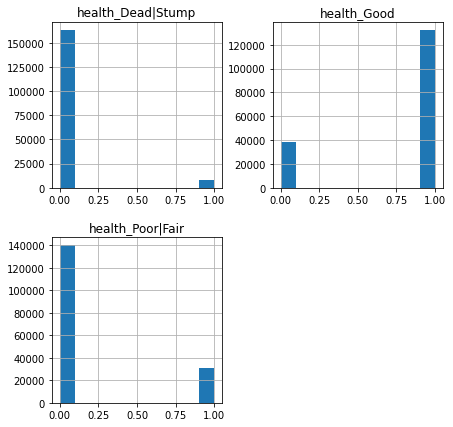

In [24]:
# Read in preprocessed data on trees.
df = pd.read_csv('./data/data_preprocessed/features.csv.gz', compression='gzip')

# Split dataset into features and targets.
x = df.loc[:, 'steward_Alive':'n_neighbors_two or more neighbors']
y = df.loc[:, 'health_Dead|Stump':]

# Split features and targets further into training, testing, and validation datasets.
x_train, x_valid, y_train, y_valid = train_test_split(x,
                                                      y,
                                                      test_size=0.5,
                                                      random_state=34,
                                                      shuffle=True,
                                                      stratify=y)

x_training, x_testing, y_training, y_testing = train_test_split(x_train,
                                                                y_train,
                                                                test_size=0.5,
                                                                random_state=34,
                                                                shuffle=True,
                                                                stratify=y_train)

# Oversampling

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1322fe220>,
      dtype=object)

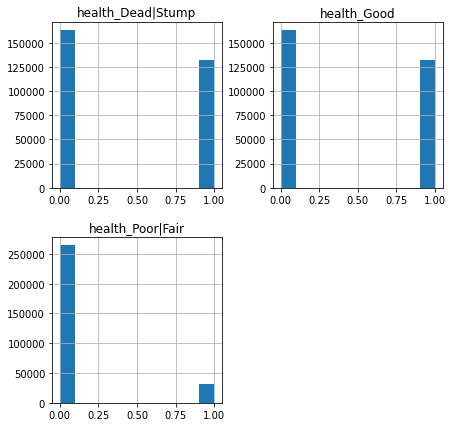

In [31]:
# Bootstrap the minority classes of the targets, i.e. pick samples of the targets randomly with replacement for
# each target class that has less samples.
ros = RandomOverSampler(sampling_strategy='minority', random_state=34)

# Fit and transform the RandomOverSampler with the original training data sets.
x_training_ros, y_training_ros = ros.fit_resample(x_training.values, y_training.values)

# Check the targets again for class imbalance.
pd.DataFrame(y_training_ros, columns=df.columns[-3:]).hist(figsize=(7, 7))

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

fig.subplots_adjust(wspace=0.5)

# Plot distribution of targets before applying any sampling technique.
fig_c = y_training.hist(ax=axs[0],
                        align='left',
                        bins=np.arange(3),
                        rwidth=0.5,
                        grid=False,
                        color='royalblue',
                        edgecolor='k',
                        linewidth=0.6)
fig_c.set_title('Distribution of targets without sampling techniques', fontsize=18, pad=20)
fig_c.spines['bottom'].set_linewidth(3)
fig_c.set_ylabel('Number of trees', fontdict={'fontsize': 13}, labelpad=20)
fig_c.grid(axis='y', alpha=0.7, color='grey', linestyle='-', linewidth=0.5)
fig_c.tick_params(axis='both', which='major', labelsize=13)

# Plot distribution of targets after oversampling.
fig_b = pd.DataFrame(y_training_ros, columns=df.columns[-3:]).hist(ax=axs[1],
                                                                   align='left',
                                                                   bins=np.arange(3),
                                                                   rwidth=0.5,
                                                                   grid=False,
                                                                   color='royalblue',
                                                                   edgecolor='k',
                                                                   linewidth=0.6)
fig_b.spines['bottom'].set_linewidth(3)
fig_b.grid(axis='y', alpha=0.7, color='grey', linestyle='-', linewidth=0.5)
fig_b.tick_params(axis='both', which='major', labelsize=13)

# Modelling

In [20]:
# Enlist various classifiers with their default parameters for experimentation.
classifiers = {
    'xgb': XGBClassifier(n_estimators=100,
                         objective='binary:logistic',
                         max_depth=8,
                         learning_rate=0.1,
                         verbosity=None,
                         booster=None,
                         tree_method=None,
                         gamma=1,
                         min_child_weight=None,
                         max_delta_step=None,
                         subsample=0.8,
                         colsample_bytree=None,
                         colsample_bylevel=None,
                         colsample_bynode=None,
                         reg_alpha=None,
                         reg_lambda=None,
                         scale_pos_weight=None,
                         base_score=None,
                         num_parallel_tree=None,
                         random_state=34,
                         n_jobs=-1,
                         monotone_constraints=None,
                         interaction_constraints=None,
                         importance_type='gain',
                         validate_parameters=None),
    'ada': AdaBoostClassifier(base_estimator=None,
                              n_estimators=50,
                              learning_rate=1.0,
                              random_state=34,
                              algorithm='SAMME.R'),
    'rdf': RandomForestClassifier(n_estimators=100,
                                  bootstrap=True,
                                  oob_score=False,
                                  n_jobs=-1,
                                  random_state=34,
                                  verbose=0,
                                  warm_start=False,
                                  class_weight=None, #'balanced',
                                  max_samples=None,
                                  criterion='gini',
                                  max_depth=None,
                                  min_samples_split=2,
                                  min_samples_leaf=1,
                                  min_weight_fraction_leaf=0.0,
                                  max_features='auto',
                                  max_leaf_nodes=None,
                                  min_impurity_decrease=0.0,
                                  min_impurity_split=None,
                                  ccp_alpha=0.0),
    'rid': RidgeClassifier(alpha=1.0,
                           fit_intercept=True,
                           normalize=False,
                           copy_X=True,
                           max_iter=None,
                           tol=0.001,
                           solver='auto',
                           random_state=34,
                           class_weight=None), #'balanced'),
    'mlp': MLPClassifier(activation='relu',
                         solver='adam',
                         alpha=0.0001,
                         batch_size='auto',
                         learning_rate='constant',
                         learning_rate_init=0.001,
                         power_t=0.5,
                         max_iter=200,
                         hidden_layer_sizes=(100,),
                         shuffle=True,
                         random_state=34,
                         tol=0.0001,
                         verbose=False,
                         warm_start=False,
                         momentum=0.9,
                         nesterovs_momentum=True,
                         early_stopping=True,
                         validation_fraction=0.1,
                         beta_1=0.9,
                         beta_2=0.999,
                         epsilon=1e-08,
                         n_iter_no_change=10,
                         max_fun=15000),
    'svc': LinearSVC(dual=True,
                     tol=0.0001,
                     C=1.0,
                     multi_class='ovr',
                     fit_intercept=True,
                     intercept_scaling=1,
                     class_weight=None, #'balanced',
                     verbose=0,
                     random_state=34,
                     max_iter=1000,
                     penalty='l2',
                     loss='squared_hinge'),
    'lgbm': LGBMClassifier(boosting_type='gbdt',
                           objective=None,
                           class_weight='balanced',
                           num_leaves=31,
                           max_depth=-1,
                           learning_rate=0.1,
                           n_estimators=100,
                           subsample_for_bin=200000,
                           min_split_gain=0.0,
                           min_child_weight=0.001,
                           min_child_samples=20,
                           subsample=1.0,
                           subsample_freq=0,
                           colsample_bytree=1.0,
                           reg_alpha=0.0,
                           reg_lambda=0.0,
                           random_state=34,
                           n_jobs=-1,
                           silent=True,
                           importance_type='split')
    }

In [5]:
# Train, predict, and evaluate the default classifiers.
models = {}

for each, clf in classifiers.items():
    models[each] = {
            'trained_clf': MultiOutputClassifier(clf).fit(x_training,
                                                          y_training)
            }
    
    # Use of the test dataset.
    models[each]['y_pred_testset'] = models[each]['trained_clf'] \
                                    .predict(x_testing)
    models[each]['accuracy_testset'] = accuracy_score(y_testing.values,
                                                      models[each]['y_pred_testset'])    
    models[each]['avg_prsc_testset'] = average_precision_score(y_testing.values,
                                                               models[each]['y_pred_testset'],
                                                               average='weighted')
    models[each]['clf_repo'] = classification_report(y_testing.values,
                                                     models[each]['y_pred_testset'],
                                                     target_names=y.columns)
    models[each]['f1_score_testset'] = f1_score(y_testing.values,
                                                models[each]['y_pred_testset'],
                                                average='weighted')
    
    # Use of the train dataset to check overfitting.
    models[each]['y_pred_trainset'] = models[each]['trained_clf'] \
                                     .predict(x_training)
    models[each]['accuracy_trainset'] = accuracy_score(y_training.values,
                                                       models[each]['y_pred_trainset'])    
    models[each]['avg_prsc_trainset'] = average_precision_score(y_training.values,
                                                                models[each]['y_pred_trainset'],
                                                                average='weighted')
    models[each]['f1_score_trainset'] = f1_score(y_training.values,
                                                 models[each]['y_pred_trainset'],
                                                 average='weighted')

    print(each, 'accuracy: ', models[each]['accuracy_testset'])
    print('CHECK:', each, 'accuracy (train data): ', models[each]['accuracy_trainset'])
    print(each, 'average precision score: ', models[each]['avg_prsc_testset'])
    print('CHECK', each, 'average precision score (train data): ', models[each]['avg_prsc_trainset'])
    print(each, 'F1 score: ', models[each]['f1_score_testset'])
    print('CHECK', each, 'F1 score (train data): ', models[each]['f1_score_trainset'], '\n')
    print(models[each]['clf_repo'])

# Create a dataframe of all algorithms, their F1 scores and their average precision scores.
f1s = pd.Series([models[each]['f1_score_testset'] for each, result in models.items()], index=list(models.keys()))
avgprsc = pd.Series([models[each]['avg_prsc_testset'] for each, result in models.items()], index=list(models.keys()))
metrics = pd.concat([f1s, avgprsc], axis=1)
metrics.columns = ['f1_score', 'avg_prsc']

# Return the results for the best three scoring algorithms.
f1s_avg = np.mean(metrics['f1_score'])
f1s_max = metrics.loc[metrics['f1_score'] == metrics['f1_score'].nlargest(3)[0]].index[0]
f1s_max_second = metrics.loc[metrics['f1_score'] == metrics['f1_score'].nlargest(3)[1]].index[0]
f1s_max_third = metrics.loc[metrics['f1_score'] == metrics['f1_score'].nlargest(3)[2]].index[0]
avg_prsc_max = metrics.loc[metrics['avg_prsc'] == metrics['avg_prsc'].nlargest(3)[0]].index[0]
avg_prsc_max_second = metrics.loc[metrics['avg_prsc'] == metrics['avg_prsc'].nlargest(3)[1]].index[0]
avg_prsc_max_third = metrics.loc[metrics['avg_prsc'] == metrics['avg_prsc'].nlargest(3)[2]].index[0]

print('---------------------------------------------------------------')
print('### Average F1 score ###:', f1s_avg)
print('### Model with highest F1 score ###:', f1s_max)
print('### Model with second highest F1 score ###:', f1s_max_second)
print('### Model with third highest F1 score ###:', f1s_max_third)
print('### Model with highest average precision score ###:', avg_prsc_max)
print('### Model with second highest average precision score ###:', avg_prsc_max_second)
print('### Model with third highest average precision score ###:', avg_prsc_max_third)

xgb accuracy:  0.8212545408810918
CHECK: xgb accuracy (train data):  0.8227579308206637
xgb average precision score:  0.7141043866649714
CHECK xgb average precision score (train data):  0.7154367873539851
xgb F1 score:  0.755870005287817
CHECK xgb F1 score (train data):  0.7577551061190976
                   precision    recall  f1-score   support

health_Dead|Stump       1.00      1.00      1.00      7904
      health_Good       0.82      0.99      0.90    132213
 health_Poor|Fair       0.55      0.05      0.09     30830

        micro avg       0.82      0.82      0.82    170947
        macro avg       0.79      0.68      0.66    170947
     weighted avg       0.78      0.82      0.76    170947
      samples avg       0.82      0.82      0.82    170947

ada accuracy:  0.8215762780276928
CHECK: ada accuracy (train data):  0.821927264005803
ada average precision score:  0.7120247097132393
CHECK ada average precision score (train data):  0.7122775162354983
ada F1 score:  0.7515616164282

# Hyperparameter optimization

In [21]:
def hypertune(model, parameters, gridsearch_clfs, allthemodels=classifiers, x_tr=x_training, y_tr=y_training):
    """
    Performs hyperparameter optimization for all of the given models, updates their default parameters with the
    best parameters after the optimization, and returns the result in a dictionary.
    
    :param model: str. Name of the algorithm to be tuned.
    :param parameters: dict. Dictionary with desired variants of hyperparameters for tuning.
    :param gridsearch_clfs: dict. Dictionary which should hold the output afterwards.
    :param allthemodels: dict. Dictionary with all pre-trained models.
    :param x_tr: numpy.ndarray. Training dataset of the features.
    :param y_tr: numpy.ndarray. Training dataset of the targets.
    
    :return: None
    """
    
    score_metric = make_scorer(f1_score, average='weighted')
    
    print('######### START HYPERPARAMETER TUNING FOR MODEL:', model, '###########################')

    gridsearch_clfs[model] = {
                        'grid_classifier': GridSearchCV(MultiOutputClassifier(allthemodels[model]),
                                                        param_grid=parameter_grid,
                                                        cv=ShuffleSplit(n_splits=7, test_size=.25, random_state=34),
                                                        scoring=score_metric,
                                                        refit=True,
                                                        verbose=0,
                                                        error_score=0,
                                                        return_train_score=False,
                                                        n_jobs=-1) \
                                          .fit(x_training_ros,
                                               y_training_ros)
                        }

    gridsearch_clfs[model]['f1_score'] = gridsearch_clfs[model]['grid_classifier'].best_score_
    print('Best F1 score: ', gridsearch_clfs[model]['f1_score'])
    
    gridsearch_clfs[model]['best_parameters'] = gridsearch_clfs[model]['grid_classifier'].best_params_
    gridsearch_clfs[model]['best_parameters'] = {i.replace('estimator__',''): v
                                                 for i, v in gridsearch_clfs[model]['best_parameters'] \
                                                .items()}

    # Return & update the set of default parameters.
    for every, param in gridsearch_clfs[model]['best_parameters'].items():
        allthemodels[model].__dict__[every] = gridsearch_clfs[model]['best_parameters'][every] 

    print('Updated parameter setting: ')
    print(allthemodels[model])
    
    print('######### FINISH #####################################################################', '\n')

### RandomForestClassifier

In [32]:
gridsearch_rdf = {}

parameter_grid = {
       'estimator__criterion': ['entropy'],
       'estimator__max_features': ['log2'],
       'estimator__n_estimators': [50]
       }

hypertune('rdf', parameter_grid, gridsearch_rdf)

######### START HYPERPARAMETER TUNING FOR MODEL: rdf ###########################
Best F1 score:  0.8581952842177463
Updated parameter setting: 
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=34, verbose=0,
                       warm_start=False)
######### FINISH ##################################################################### 



### LGBMClassifier

In [33]:
gridsearch_lgbm = {}

parameter_grid = {
       'estimator__boosting_type': ['dart'],
       'estimator__num_leaves': [130],
       'estimator__learning_rate': [0.9],
       'estimator__n_estimators': [95],
       'estimator__reg_lambda': [0.0],
       'estimator__subsample': [0.1],
       'estimator__min_child_weight': [0.00001],
       'estimator__subsample_for_bin': [50000]
       }

hypertune('lgbm', parameter_grid, gridsearch_lgbm)

######### START HYPERPARAMETER TUNING FOR MODEL: lgbm ###########################
Best F1 score:  0.8822638399352619
Updated parameter setting: 
LGBMClassifier(boosting_type='dart', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split', learning_rate=0.9,
               max_depth=-1, min_child_samples=20, min_child_weight=1e-05,
               min_split_gain=0.0, n_estimators=95, n_jobs=-1, num_leaves=130,
               objective=None, random_state=34, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=0.1, subsample_for_bin=50000,
               subsample_freq=0)
######### FINISH ##################################################################### 



# Testing with optimized hyperparameters

### RandomForestClassifier

In [34]:
tuned_classifier = MultiOutputClassifier(classifiers['rdf']).fit(x_training_ros, y_training_ros)
y_pred_valid = tuned_classifier \
              .predict(x_valid.values)
accuracy_valid = accuracy_score(y_valid.values,
                                y_pred_valid)
f1_valid = f1_score(y_valid,
                    y_pred_valid,
                    average='weighted')
average_precision_valid = average_precision_score(y_valid.values,
                                                  y_pred_valid)

# For comparison (to check overfitting), use train dataset.
y_pred_train = tuned_classifier \
              .predict(x_train.values)
accuracy_train = accuracy_score(y_train.values,
                                y_pred_train)
f1_train = f1_score(y_train,
                    y_pred_train,
                    average='weighted')
average_precision_train = average_precision_score(y_train.values,
                                                  y_pred_train)


clf_report = classification_report(y_valid.values,
                                   y_pred_valid,
                                   target_names=y.columns)

print('Accuracy: ', accuracy_valid)
print('CHECK Accuracy (train data): ', accuracy_train)
print('F1 score: ', f1_valid)
print('CHECK F1 score (train data): ', f1_train)
print('Average precision score:', average_precision_valid,)
print('CHECK Average precision score (train data):', average_precision_train, '\n')
print(clf_report)

Accuracy:  0.8214768320005615
CHECK Accuracy (train data):  0.8222402265029513
F1 score:  0.7562471519707764
CHECK F1 score (train data):  0.7574429494249487
Average precision score: 0.6723880102617308
CHECK Average precision score (train data): 0.6732496377308502 

                   precision    recall  f1-score   support

health_Dead|Stump       1.00      1.00      1.00     15808
      health_Good       0.82      0.99      0.90    264425
 health_Poor|Fair       0.55      0.05      0.10     61661

        micro avg       0.82      0.82      0.82    341894
        macro avg       0.79      0.68      0.66    341894
     weighted avg       0.78      0.82      0.76    341894
      samples avg       0.82      0.82      0.82    341894



### LGBMClassifier

In [35]:
tuned_classifier = MultiOutputClassifier(classifiers['lgbm']).fit(x_training, y_training)
y_pred_valid = tuned_classifier \
              .predict(x_valid.values)
accuracy_valid = accuracy_score(y_valid.values,
                                y_pred_valid)
f1_valid = f1_score(y_valid,
                    y_pred_valid,
                    average='weighted')
average_precision_valid = average_precision_score(y_valid.values,
                                                  y_pred_valid)

# For comparison (to check overfitting), use train dataset.
y_pred_train = tuned_classifier \
              .predict(x_train.values)
accuracy_train = accuracy_score(y_train.values,
                                y_pred_train)
f1_train = f1_score(y_train,
                    y_pred_train,
                    average='weighted')
average_precision_train = average_precision_score(y_train.values,
                                                  y_pred_train)


clf_report = classification_report(y_valid.values,
                                   y_pred_valid,
                                   target_names=y.columns)

print('Accuracy: ', accuracy_valid)
print('CHECK Accuracy (train data): ', accuracy_train)
print('F1 score: ', f1_valid)
print('CHECK F1 score (train data): ', f1_train)
print('Average precision score:', average_precision_valid,)
print('CHECK Average precision score (train data):', average_precision_train, '\n')
print(clf_report)

Accuracy:  0.6743464348599273
CHECK Accuracy (train data):  0.6744254067050022
F1 score:  0.7772768748978183
CHECK F1 score (train data):  0.7777993101955812
Average precision score: 0.6800282349812562
CHECK Average precision score (train data): 0.6801963604923729 

                   precision    recall  f1-score   support

health_Dead|Stump       1.00      1.00      1.00     15808
      health_Good       0.83      0.92      0.87    264425
 health_Poor|Fair       0.27      0.37      0.31     61661

        micro avg       0.72      0.82      0.77    341894
        macro avg       0.70      0.76      0.73    341894
     weighted avg       0.74      0.82      0.78    341894
      samples avg       0.75      0.82      0.77    341894



# Save / load current status

In [15]:
with open('tuned_lgbm_clf.pkl', 'wb') as handle:
    pickle.dump(gridsearch_lgbm, handle)

In [8]:
with open('gridsearch_lgbm_clfs.pkl', 'rb') as handle:
    gridsearch_lgbm = pickle.load(handle)